# Imports

In [105]:
import tensorflow as tf
import numpy as np
import scipy
import skimage.color
import skimage.io
import skimage.transform
from skimage.measure import find_contours
from numpy import array
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import colorsys
import random


import stone

from PIL import Image
from distutils.version import LooseVersion

# Preprocessing

In [63]:
# Taking the image

image = Image.open('creek_00001.jpg')
sample_image = np.array(image)
sample_image.shape

(550, 688, 3)

In [64]:
# Setting up the configuration file. This would be called from stone.py.

class InferenceConfig(stone.StoneConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [65]:
def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL



In [66]:
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

In [67]:
def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)

In [68]:
def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

In [69]:
 def mold_inputs(config,images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

# Calculating molded images, images meta data and windows

The original location of our input image in the molded image is given by windows 

In [70]:
molded_images, image_metas, windows = mold_inputs(config, [sample_image])

In [71]:
image_shape = molded_images[0].shape

for g in molded_images[1:]:
    assert g.shape == image_shape

In [72]:
def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])


In [73]:
def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

In [74]:
def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

In [75]:
def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.divide((boxes - shift), scale).astype(np.float32)

In [76]:
 def get_anchors(image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(config, image_shape)
        # Cache anchors and reuse if image shape is the same
        
        _anchor_cache = {}
        if not tuple(image_shape) in _anchor_cache:
            # Generate Anchors
            a = generate_pyramid_anchors(
                config.RPN_ANCHOR_SCALES,
                config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                config.BACKBONE_STRIDES,
                config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            anchors = a
            # Normalize coordinates
            _anchor_cache[tuple(image_shape)] = norm_boxes(a, image_shape[:2])
        return _anchor_cache[tuple(image_shape)]

# Calculating anchors

In [77]:
anchors = get_anchors(image_shape)
anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

In [78]:
def load_graph(mask_rcnn_stone):
    with tf.gfile.GFile(mask_rcnn_stone, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
        graph_def,
        input_map=None,
        return_elements=None,
        name="prefix",
        op_dict=None,
        producer_op_list=None
        )
    
    return graph

# Processing (Loading the graph)

In [79]:
graph=load_graph("../../Model/mask_rcnn_stone.pb")

for op in graph.get_operations():
    print(op.name)

prefix/input_image
prefix/input_image_meta
prefix/input_anchors
prefix/zero_padding2d_1/Pad/paddings
prefix/zero_padding2d_1/Pad
prefix/conv1/kernel
prefix/conv1/kernel/read
prefix/conv1/bias
prefix/conv1/bias/read
prefix/conv1/convolution
prefix/conv1/BiasAdd
prefix/bn_conv1/gamma
prefix/bn_conv1/gamma/read
prefix/bn_conv1/beta
prefix/bn_conv1/beta/read
prefix/bn_conv1/moving_mean
prefix/bn_conv1/moving_mean/read
prefix/bn_conv1/moving_variance
prefix/bn_conv1/moving_variance/read
prefix/bn_conv1/FusedBatchNorm
prefix/activation_1/Relu
prefix/max_pooling2d_1/MaxPool
prefix/res2a_branch2a/kernel
prefix/res2a_branch2a/kernel/read
prefix/res2a_branch2a/bias
prefix/res2a_branch2a/bias/read
prefix/res2a_branch2a/convolution
prefix/res2a_branch2a/BiasAdd
prefix/bn2a_branch2a/gamma
prefix/bn2a_branch2a/gamma/read
prefix/bn2a_branch2a/beta
prefix/bn2a_branch2a/beta/read
prefix/bn2a_branch2a/moving_mean
prefix/bn2a_branch2a/moving_mean/read
prefix/bn2a_branch2a/moving_variance
prefix/bn2a_bran

prefix/mrcnn_detection/map/while/PadV2
prefix/mrcnn_detection/map/while/TensorArrayWrite/TensorArrayWriteV3/Enter
prefix/mrcnn_detection/map/while/TensorArrayWrite/TensorArrayWriteV3
prefix/mrcnn_detection/map/while/add_1/y
prefix/mrcnn_detection/map/while/add_1
prefix/mrcnn_detection/map/while/NextIteration
prefix/mrcnn_detection/map/while/NextIteration_1
prefix/mrcnn_detection/map/while/NextIteration_2
prefix/mrcnn_detection/map/while/Exit_2
prefix/mrcnn_detection/map/TensorArrayStack/TensorArraySizeV3
prefix/mrcnn_detection/map/TensorArrayStack/range/start
prefix/mrcnn_detection/map/TensorArrayStack/range/delta
prefix/mrcnn_detection/map/TensorArrayStack/range
prefix/mrcnn_detection/map/TensorArrayStack/TensorArrayGatherV3
prefix/mrcnn_detection/Reshape/shape
prefix/mrcnn_detection/Reshape
prefix/mrcnn_detection/Greater_1/y
prefix/mrcnn_detection/Greater_1
prefix/mrcnn_detection/Where_2
prefix/mrcnn_detection/strided_slice_25/stack
prefix/mrcnn_detection/strided_slice_25/stack_1
pre

To do the prediction, we have to input ('prefix/input_image' i.e. molded_images, 'prefix/input_anchors' i.e. anchors and 'prefix/input_image_meta' i.e. image_metas).

The output of sess.run produces a list [output_1 to output_7] in the original graph above of which we need 1st element (i.e. detections) and 4th element (i.e. mrcnn_mask)

The predictions list is called "Batches".

In [ ]:
x = graph.get_tensor_by_name('prefix/input_image:0')
x5 = graph.get_tensor_by_name('prefix/input_anchors:0')
x4 = graph.get_tensor_by_name('prefix/input_image_meta:0')
y7 = graph.get_tensor_by_name('prefix/output_7:0')
y2 = graph.get_tensor_by_name('prefix/output_2:0')
y3 = graph.get_tensor_by_name('prefix/output_3:0')
y4 = graph.get_tensor_by_name('prefix/output_4:0')
y5 = graph.get_tensor_by_name('prefix/output_5:0')
y6 = graph.get_tensor_by_name('prefix/output_6:0')
y1 = graph.get_tensor_by_name('prefix/output_1:0')

y=[y1,y2,y3,y4,y5,y6,y7]

In [81]:
with tf.Session(graph=graph) as sess:
    
    #x_1 = list(pix_val)
    batches = sess.run(y, feed_dict={x4: image_metas, x:molded_images, x5:anchors})
    
    outs = []
    num_samples = 1
    for batch_out in batches:
        shape = (num_samples,) + batch_out.shape[1:]
        outs.append(np.zeros(shape, dtype=batch_out.dtype))

In [82]:
for i, batch_out in enumerate(batches):
    outs[i][0:1] = batch_out

In [83]:
def unpack_singleton(batches):
    """Gets the first element if the iterable has only one value.

    Otherwise return the iterable.

    # Argument:
        x: A list or tuple.

    # Returns:
        The same iterable or the first element.
    """
    if len(batches) == 1:
        return batches[0]
    return batches

In [84]:
detections = batches[0]
mrcnn_mask = batches[3]

In [85]:
def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.around(np.multiply(boxes, scale) + shift).astype(np.int32)

In [86]:
def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.

    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = resize(mask, (y2 - y1, x2 - x1))
    mask = np.where(mask >= threshold, 1, 0).astype(np.bool)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2], dtype=np.bool)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask

In [87]:
def unmold_detections(detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

In [88]:
results =[]

for i, image in enumerate([sample_image]):
    final_rois, final_class_ids, final_scores, final_masks = unmold_detections(detections[i], mrcnn_mask[i],
                                       sample_image.shape, molded_images[i].shape,
                                       windows[i])
    
    results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })

# Postprocessing

In [95]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [98]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [99]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

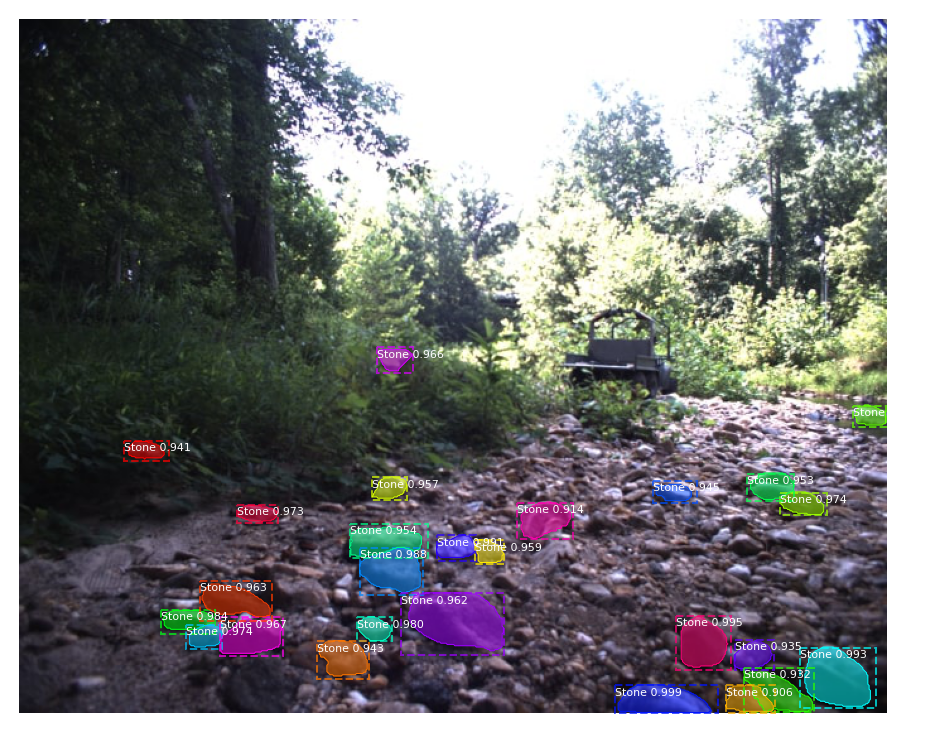

In [106]:
r = results[0]
class_names = ['BG', 'Stone']

display_instances(sample_image, r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])